In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
df.describe()

<ipython-input-4-ea8415b8a3ee>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


### Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand.

In [5]:
logins_df = df.set_index('login_time')

In [6]:
logins_df['countfifteenmin'] = 0
logins_df = logins_df.resample('15min').count()
logins_df.head()

,countfifteenmin
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [7]:
logins_df = logins_df.reset_index()

In [8]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   login_time       9788 non-null   datetime64[ns]
 1   countfifteenmin  9788 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 153.1 KB


<AxesSubplot:title={'center':'Total logins observed'}>

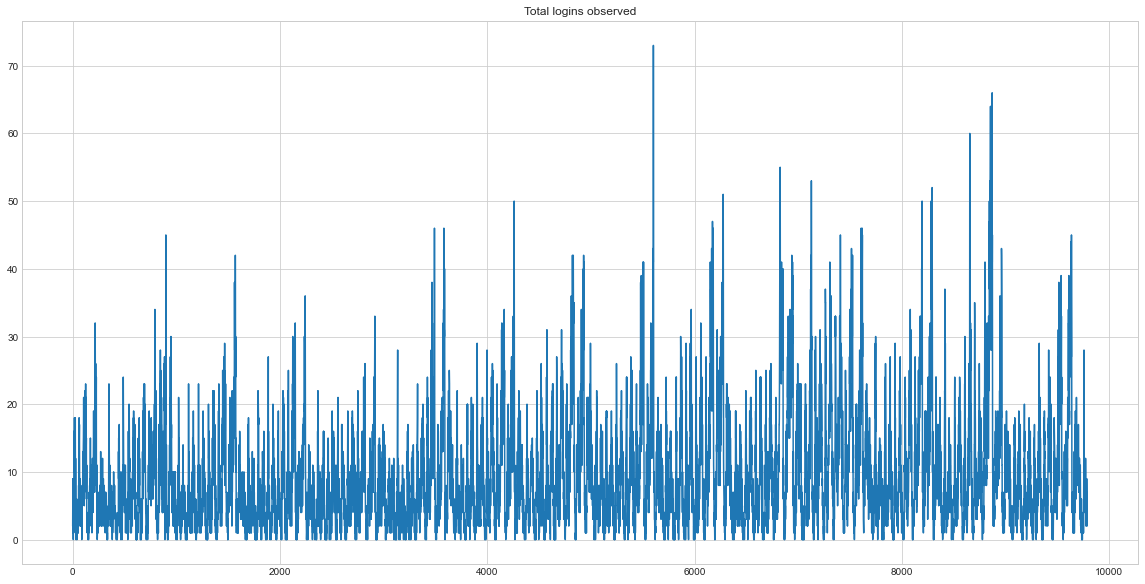

In [9]:
plt.style.use('seaborn-whitegrid')
fig= plt.figure(figsize=(20,10))
season = seasonal_decompose(logins_df['countfifteenmin'], model='additive', period= 96)

plt.title('Total logins observed')
season.observed.plot()

In [10]:
logins_df['Weekday'] = logins_df['login_time'].dt.day_name()
logins_df.head()

,login_time,countfifteenmin,Weekday
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday


In [11]:
Weekday_df = logins_df.groupby('Weekday', as_index=False).sum()
Weekday_df

,Weekday,countfifteenmin
0,Friday,15208
1,Monday,8823
2,Saturday,19377
3,Sunday,18167
4,Thursday,11960
5,Tuesday,9268
6,Wednesday,10339


Text(0.5, 1.0, 'Logins by Day of week')

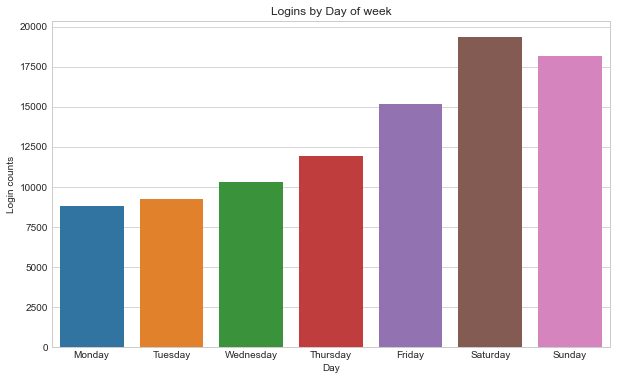

In [12]:
fig = plt.figure(figsize=(10,6))
order_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday','Saturday','Sunday']

sns.barplot(x='Weekday', y='countfifteenmin', data=Weekday_df, order=order_week)
plt.xlabel('Day')
plt.ylabel('Login counts')
plt.title('Logins by Day of week')

In [13]:
logins_df['Hour'] = logins_df['login_time'].dt.hour
logins_df.head()

,login_time,countfifteenmin,Weekday,Hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21


In [14]:
hour_df = logins_df.groupby('Hour', as_index=False).sum()
hour_df.head()

,Hour,countfifteenmin
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


Text(0.5, 1.0, 'Logins by Hour')

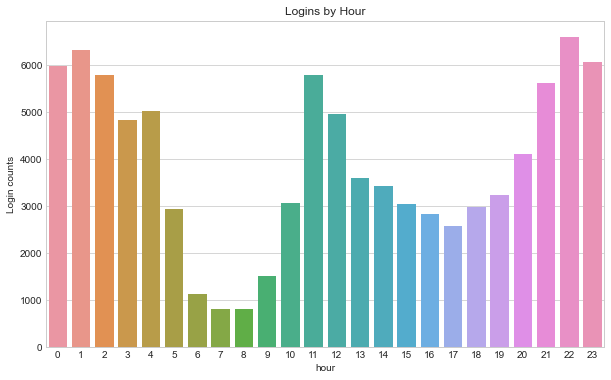

In [15]:
fig = plt.figure(figsize=(10,6))
sns.barplot(x='Hour', y='countfifteenmin', data=hour_df)
plt.xlabel('hour')
plt.ylabel('Login counts')
plt.title('Logins by Hour')

In [16]:
df_day_hour = logins_df.groupby(['Weekday', 'Hour'], as_index=False).sum()
df_day_hour.head()

,Weekday,Hour,countfifteenmin
0,Friday,0,975
1,Friday,1,957
2,Friday,2,771
3,Friday,3,502
4,Friday,4,353


<Figure size 1440x720 with 0 Axes>

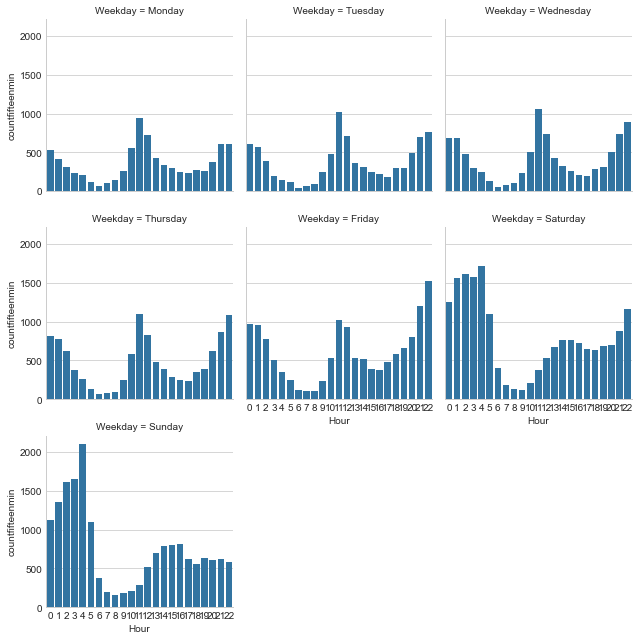

In [17]:
fig = plt.figure(figsize=(20,10))
grid = sns.FacetGrid(df_day_hour, col='Weekday', col_wrap=3, col_order=order_week)
grid.map(sns.barplot, 'Hour','countfifteenmin', order=range(0,23))

By observing the plots, the logins occur the most in Saturday and Sunday and most active at late nights from 21 - 2. The logins start to increase from 21 and peak at 22.

### Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

I would choose weekend engagement for drivers in the city other than their primary weekday city. With the huge difference in peak times during the weekdays, it is unlikely that any driver would take advantage of both cities as that would equate to working more than 12 hours a day. However, with weekends being active for both throughout the day, it is more reasonable to expect a driver to take customers back and forth with tolls not being an issue.

2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment

To investigate the effectiveness of the proposed change, I would compare two groups of drivers with/without reimbursements and measure the key measures mentioned above. I would recommend dividing the drivers at random by 50\% and 50\% for each group, one for the drivers offered reimbursement and the other for remaining drivers continuing to operate without being reimbursed for tolls.

b) what statistical test(s) you will conduct to verify the significance of the
observation

To verify the significance of the observation, I perform the A/B test on those two groups. I perform the t-test with a confidence level of 95\%, where the null hypothesis is the reimbursing drivers for tolls does not have a statistically significant impact on Ultimate's net profits.

c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

If the increased revenue is positive, then it is effective to encourage driver partners by reimbursing toll costs. If the increased revenue is negative, they should not adopt the toll cost reimbursement. Even it is revealed the increased revenue is positive, the drivers have randomly chosen, and it may not be effective in all cases. We need more rigorous experiments by different variables (e.g., selecting other drivers, differnt portions, different days, etc.)


### Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

### Data Wrangling

In [18]:
'''
df_ut = pd.read_json('ultimate_data_challenge.json')
df_ut.head()
'''

"\ndf_ut = pd.read_json('ultimate_data_challenge.json')\ndf_ut.head()\n"

In [19]:
with open("ultimate_data_challenge.json","r") as read_file:
    ultimate_data = json.load(read_file)
    
df_ut = pd.DataFrame(ultimate_data)

In [20]:
df_ut.shape

(50000, 12)

In [21]:
df_ut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


#### Handling Missing Values

In [22]:
df_ut[df_ut['avg_rating_of_driver'].isnull()].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0


In [23]:
df_ut.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [24]:
df_ut =df_ut.dropna()
df_ut.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [25]:
df_ut.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,2.609675,4.601720,1.073822,8.898709,61.254897,5.460046,4.776446
std,4.059336,0.616104,0.198747,18.322061,34.813848,5.145174,0.404606
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,37.500000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.780000,5.000000
75%,3.000000,5.000000,1.070000,11.100000,100.000000,6.490000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000


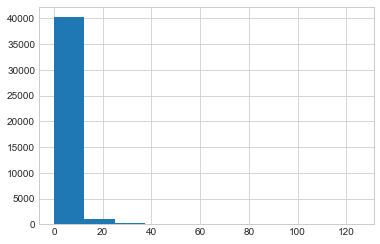

In [26]:
plt.hist(df_ut['trips_in_first_30_days'])
plt.show()

In [27]:
#checking to see how many outliers to remove
for trips in np.arange(40,120,20):
    num_of_trips = np.sum(df_ut['trips_in_first_30_days']>trips)
    print('Number of trips over {}: {}'.format(trips, num_of_trips))

Number of trips over 40: 35
Number of trips over 60: 4
Number of trips over 80: 1
Number of trips over 100: 1


In [28]:
#Drop rows where users took over 60 trips in their first 30 days
df_ut = df_ut.drop(df_ut[df_ut['trips_in_first_30_days'] > 60].index)

#check again
for trips in np.arange(40,120,20):
    num_of_trips = np.sum(df_ut['trips_in_first_30_days']>trips)
    print('Number of trips over {}: {}'.format(trips, num_of_trips))

Number of trips over 40: 31
Number of trips over 60: 0
Number of trips over 80: 0
Number of trips over 100: 0


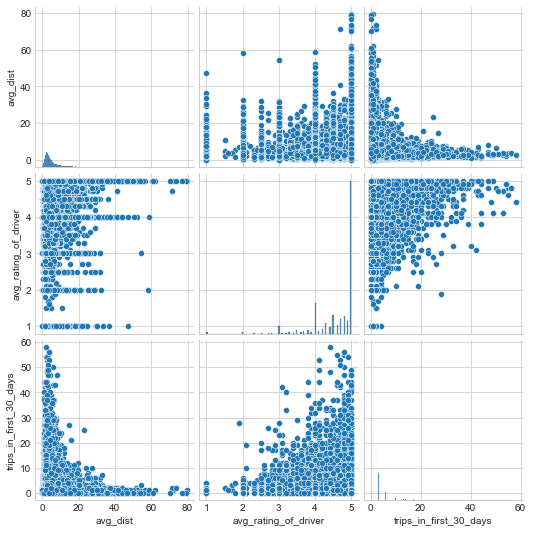

In [29]:
columns_list = ['avg_dist', 'avg_rating_of_driver', 'trips_in_first_30_days']
df_visual = df_ut.loc[:, columns_list]
sns.pairplot(df_visual)
plt.show()

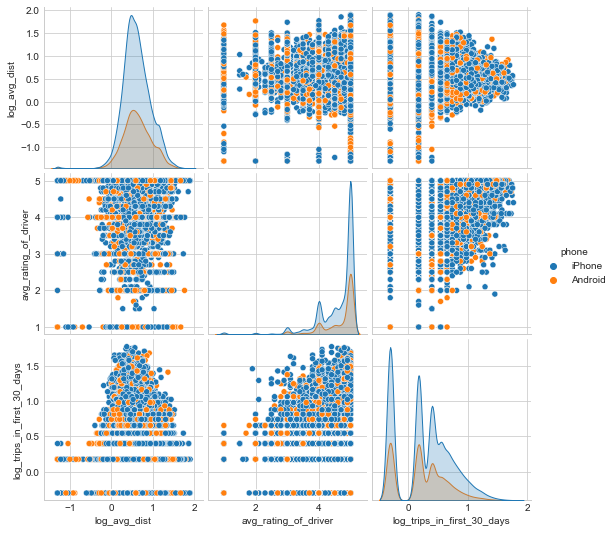

In [30]:
%matplotlib inline

df_ut['log_avg_dist'] = np.log10(df_ut['avg_dist']+0.05)
df_ut['log_trips_in_first_30_days'] = np.log10(df_ut['trips_in_first_30_days']+0.5)

columns_list = ['log_avg_dist', 'avg_rating_of_driver', 'log_trips_in_first_30_days','phone','city']
df_visual = df_ut.loc[:, columns_list]
#Color code by phone
sns.pairplot(df_visual, hue='phone', diag_kind='kde')

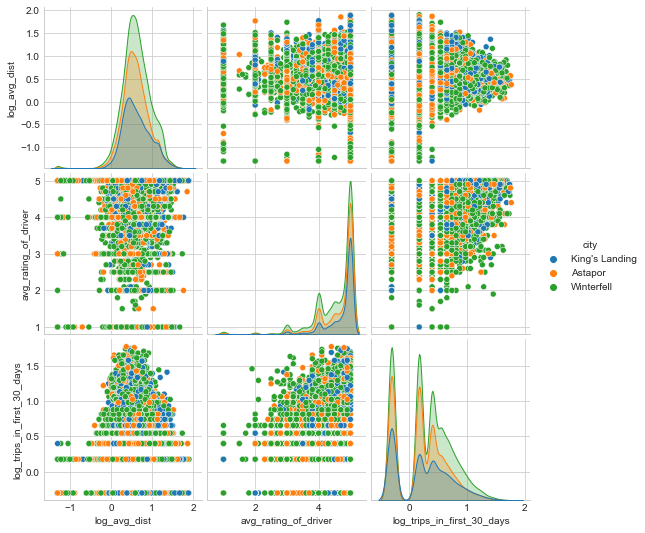

In [31]:
#Color code by city
sns.pairplot(df_visual, hue='city', diag_kind='kde')

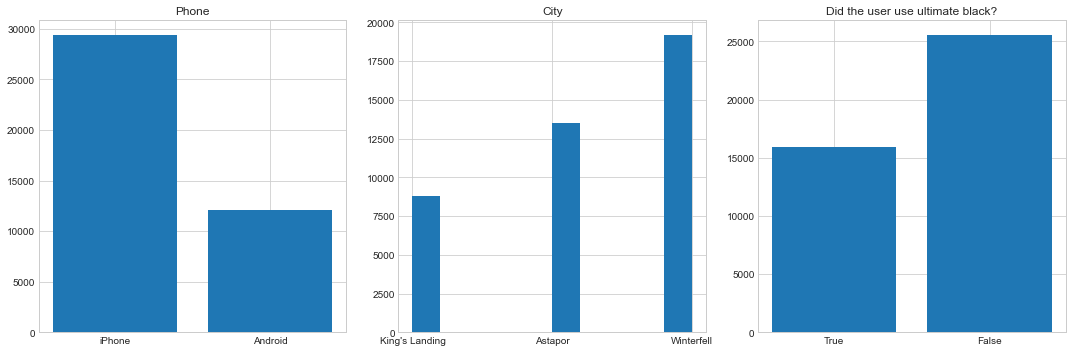

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Phone')
plt.bar(['iPhone', 'Android'], [np.sum(df_ut['phone'] == 'iPhone'), np.sum(df_ut['phone'] == 'Android')])
plt.subplot(1,3,2)
plt.title('City')
plt.hist(df_ut['city'])
plt.subplot(1,3,3)
plt.title('Did the user use ultimate black?')
plt.bar(['True', 'False'], [np.sum(df_ut['ultimate_black_user']),np.sum(df_ut['ultimate_black_user']==0)])
plt.tight_layout()
plt.show()

In [33]:
#Converting columns to dates
df_ut['signup_date'] = pd.to_datetime(df_ut['signup_date'])
df_ut['last_trip_date'] = pd.to_datetime(df_ut['last_trip_date'])

#Check last date
sorted(df_ut['last_trip_date'], reverse=True)[0]

Timestamp('2014-07-01 00:00:00')

In [34]:
#Create user_retained column if user took atrip in last 30 days
df_ut['user_retained'] = df_ut['last_trip_date'] > '2014-06-01'
np.sum(df_ut['user_retained'])/ len(df_ut['user_retained'])

#Drop log transformed columns used for visualization
df_ut = df_ut.drop(['log_avg_dist', 'log_trips_in_first_30_days'],axis=1)

In [35]:
def categorical_bar_graph(df, column_name):
    cross_tab = pd.crosstab(df[column_name], df['user_retained'])
    num_categories = len(cross_tab.index)
    x_vals = np.arange(num_categories) +1
    x_labels = cross_tab.index.values
    y_vals = np.empty(num_categories)
    for i in range(num_categories):
        y_vals[i] = cross_tab.iloc[i,1]/np.sum(cross_tab.iloc[i,0:2])
        
    return x_labels, x_vals, y_vals

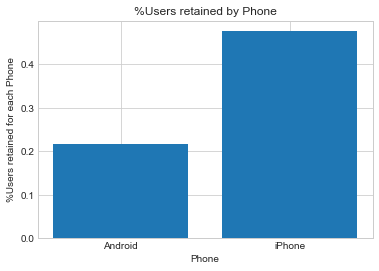

In [36]:
x_labels, x, y =categorical_bar_graph(df_ut, 'phone')

plt.bar(x,y)
plt.title('%Users retained by Phone')
plt.xlabel('Phone')
plt.ylabel('%Users retained for each Phone')
plt.xticks(x, x_labels)
plt.show()

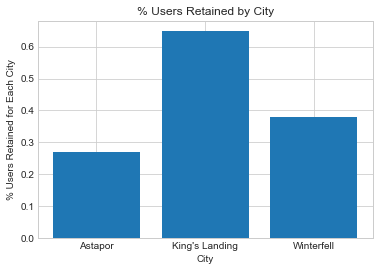

In [37]:
x_labels, x, y= categorical_bar_graph(df_ut, 'city')
plt.bar(x,y)
plt.title('% Users Retained by City')
plt.xlabel('City')
plt.ylabel('% Users Retained for Each City')
plt.xticks(x, x_labels)
plt.show()

C:\Users\dongh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\dongh\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


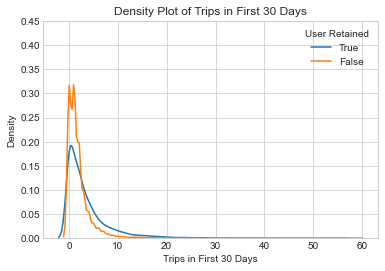

In [38]:
for category in df_ut['user_retained'].unique():
    subset = df_ut[df_ut['user_retained']==category]
    sns.distplot(subset['trips_in_first_30_days'], hist=False, label=category)
    
plt.legend(title='User Retained')
plt.title('Density Plot of Trips in First 30 Days')
plt.xlabel('Trips in First 30 Days')
plt.ylabel('Density')
plt.ylim(0,0.45)
plt.show()

In [39]:
#Drop independent variable column
dfx = df_ut.drop('user_retained', axis=1)

#Change signup date to days since first signup date
dfx['signup_delta'] = (df_ut['signup_date'] - df_ut['signup_date'].min())/np.timedelta64(1,'D')

#Create dummy variables for categorical variables
dummy_city = pd.get_dummies(dfx['city'], drop_first = True)
dummy_phone = pd.get_dummies(dfx['phone'], drop_first=True)
dfx = pd.concat([dfx, dummy_city, dummy_phone], axis=1)

#Drop datetime and categorical columns
dfx= dfx.drop(['last_trip_date','signup_date','city','phone'], axis=1)
dfx.astype(float)

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_delta,King's Landing,Winterfell,iPhone
0,4.0,4.7,1.10,15.4,1.0,46.2,3.67,5.0,24.0,1.0,0.0,1.0
1,0.0,5.0,1.00,0.0,0.0,50.0,8.26,5.0,28.0,0.0,0.0,0.0
2,3.0,4.3,1.00,0.0,0.0,100.0,0.77,5.0,5.0,0.0,0.0,1.0
3,9.0,4.6,1.14,20.0,1.0,80.0,2.36,4.9,9.0,1.0,0.0,1.0
4,14.0,4.4,1.19,11.8,0.0,82.4,3.13,4.9,26.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49993,3.0,4.8,1.11,11.1,1.0,55.6,2.53,4.7,2.0,0.0,0.0,1.0
49994,1.0,4.6,1.44,37.5,0.0,25.0,2.25,4.5,2.0,0.0,0.0,1.0
49995,0.0,5.0,1.00,0.0,0.0,100.0,5.63,4.2,24.0,1.0,0.0,1.0
49997,0.0,5.0,1.00,0.0,1.0,100.0,3.86,5.0,30.0,0.0,1.0,0.0


In [40]:
import statsmodels.api as sm

#Create dependent and independent variables
X= dfx.astype(float)
y =df_ut['user_retained']

#Create and fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.561648
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.166     
Dependent Variable:   user_retained      AIC:                46574.5275
Date:                 2021-11-23 20:53   BIC:                46678.1119
No. Observations:     41441              Log-Likelihood:     -23275.   
Df Model:             11                 LL-Null:            -27902.   
Df Residuals:         41429              LLR p-value:        0.0000    
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       6.0000                                           
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
trips_in_first_30_days  0.1066   0.0035  30.4282 0.0000  0.0997  0.1135
avg_rating_of_driver   -0.0807   0.0168  -4.7933 0.0000 -0.1137 -0.0477
avg_surge              -0.4986   0.0858  -5.8109 0.0000 -0.6667 -0.3304
surge_pct               0.0064   0.0010   6.6353 0.0000  0.0045  0.0083
ultimate_black_user     0.9388   0.0233  40.2700 0.0000  0.8931  0.9845
weekday_pct             0.0009   0.0003   2.7871 0.0053  0.0003  0.0016
avg_dist               -0.0378   0.0025 -15.3580 0.0000 -0.0426 -0.0330
avg_rating_by_driver   -0.3059   0.0209 -14.6032 0.0000 -0.3469 -0.2648
signup_delta           -0.0060   0.0013  -4.6738 0.0000 -0.0085 -0.0035
King's Landing          1.7556   0.0325  54.0934 0.0000  1.6920  1.8193
Winterfell              0.5455   0.0264  20.6601 0.0000  0.4938  0.5973
iPhone                  1.1448   0.0268  42.6506 0.0000  1.0922  1.1974
=======================================================================

"""

C:\Users\dongh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


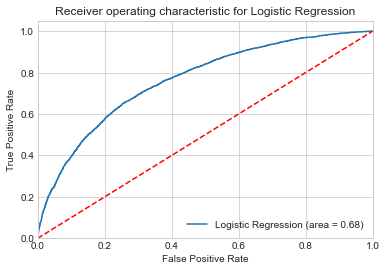

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

#Create training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#Create and train logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#Get predictions for our logistic regression model
y_pred = logreg.predict(X_test)

#Generate AUC score
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

We found that three of our features have missing values. Since we have 50,000 data points, we can remove the rows with missing values without it having a drastic effect on our data. Using our describe function, we can see that our values make sense (ratings between 1 and 5, percentages between 0 and 100). There were some extreme values in the trips_in_first_30_days variable, and we removed the users with those extreme values to make it easier to visualize our data. We can also see that most of our numerical data lies on an extreme (most users averaged 0-10 miles per trip in their first 30 days, most drivers had an average rating of 4.5 to 5, etc.), but our categorical variables were more balanced. 

Logistic regression model is well suited to a binary classification problem and fairly interpretable. While models such as random forest and support vector machines are also well suited to classification problems, they are not as easy to interpret. The AUC score for our logistic regression model was 0.69, whose interpretation is context dependent and requires a baseline model or other models for comparison.

Although all of our variables had low p-values, it can be more useful to look at the magnitude of the coefficients. The large coefficients for our iPhone variable suggest that users who signed up using an iPhone are more likely to be retained. There might be something about the Android application that could be dissuading users from using it more, such as missing features or poor UI design.